#Montar ruta de drive

In [1]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


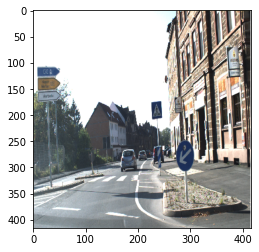

In [7]:
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

input_w, input_h = 416, 416
photo_filename = '/drive/My Drive/Dataset_TrafficSignals/ObjectDetectionTutorial/00002.ppm'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
im_arr = np.asarray(image[0])
plt.imshow(im_arr)

#Sacar los Numpy

In [ ]:
import numpy as np
from tqdm import tqdm

x_train = np.load('/drive/My Drive/Dataset_TrafficSignals/x_train_traffic.npy')
x_test = np.load('/drive/My Drive/Dataset_TrafficSignals/x_test_traffic.npy')

y_train = np.load('/drive/My Drive/Dataset_TrafficSignals/y_train_traffic.npy')
y_test = np.load('/drive/My Drive/Dataset_TrafficSignals/y_test_traffic.npy')



print(x_train.shape)
print(x_test.shape)

(26640, 32, 32, 3)
(12630, 32, 32, 3)


##Ejemplo de imagen



5


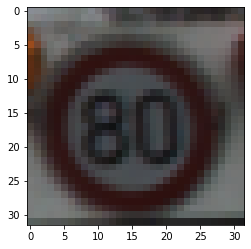

In [ ]:
import matplotlib.pyplot as plt
import random
i = random.randint(0,26640)
im = x_train[i]
im_arr = np.asarray(im)
plt.imshow(im_arr)
print(list(y_train[i]).index(1))

#Red Convolucional

In [ ]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

batch_size = 50
epochs = 100
num_classes = 43

#DATA AUGMENTATION#
datagen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=20,
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

#FUNCION QUE CREA LAS CAPAS DE CONVOLUCION#

def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(BN())

  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(BN())

  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(BN())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  
  return model

#CONFIGURACIÓN DE LA RED NEURONAL#
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

## DESCENSO POR GRADIENTE Y COMPILACIÓN
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#LEARINING RATE ANNEALING#

def scheduler(epoch):
    if epoch < 50:
        return .1
    elif epoch < 75:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

## TRAINING
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', round(scores[0],4))
print('Test accuracy:', round(scores[1],4))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0

#Guardado del modelo de clasificación

In [ ]:
model.save('/drive/My Drive/Dataset_TrafficSignals/classification_model.h5')
model.save_weights('/drive/My Drive/Dataset_TrafficSignals/classification_model_ONLY_WEIGHTS.h5')

#Ejemplo de predicción

[5]


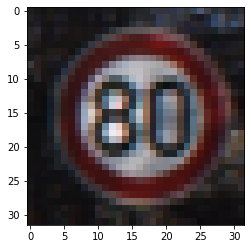

In [ ]:
i = random.randint(0,12630)
im = x_test[i]
im_arr = np.asarray(im)
plt.imshow(im_arr)
print(np.argmax(model.predict(np.asarray([x_test[i]])), axis=-1))